# Symbolic calculations

In [1]:
import math, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections.abc import Callable
import sympy
from  sympy import *
init_printing(use_unicode=False, wrap_line=False)

## Analytical formulas

The Hull-White Model

(see Damiano Brigo and Fabio Mercurio "Interest Rate Models Theory and Practice")

$$
\text{d}r(t) = \left[\theta(t)-a r(t)\right] \text{d}t + \sigma \text{d}W(t)
$$
With market-observable discount factors (zero-coupon bonds) $P(0,t)$:
\begin{eqnarray}
f(0,T) &=& -\frac{\partial \text{ln} P(0,T)}{\partial T}
\\
\theta(t) &=& \frac{\partial{f(0,t)}}{\partial t} + a f(0,t) + \frac{\sigma^2}{2a}(1-e^{-2 a t})
\end{eqnarray}

In [2]:
class HullWhiteAnalytical:

    def __init__ (self):
        self.t, self.T, self.sigma, self.a = symbols('t T sigma a', real = True, positive = True)
        self.r = symbols('r', real = True)
        self.P0_t = exp(-self.r*self.t)
    
    def P0 (self, t):
        return self.P0_t.subs(self.t,t)
    
    def f0 (self):
        return diff(-log(self.P0(self.t)),self.t)
    
    def r0 (self):
        return self.f0().subs(self.t,0)
    
    def alpha (self):
        return self.f0() + self.sigma**2/(2*self.a**2) * (1-exp(-self.a*self.t))**2
    
    def r_mean (self):
        alpha_t = self.alpha()
        alpha_0 = alpha_t.subs(self.t,0)
        return exp(-self.a*self.t)*(self.r0()-alpha_0) + alpha_t
    
    def r_variance (self):
        return self.sigma**2/(2*self.a) * (1-exp(-2*self.a*self.t))
    
    def theta (self):
        z1 = diff(self.f0(),self.t)
        z2 = self.a*self.f0()
        z3 = self.sigma**2/(2*self.a)*(1-exp(-2*self.a*self.t))
        return z1+z2+z3
    
    def theta_lambdify (self):
        return lambdify([self.a,self.sigma,self.r,self.t],self.theta())
        
    def A (self):
        e1 = self.P0(self.T)/self.P0(self.t)
        e2 = self.B() * self.f0()
        e3 = self.sigma**2/(4*self.a) * (1-exp(-2*self.a*self.t)) * self.B()**2
        return e1*exp(e2-e3)

    def B (self):
        return (1 - exp(-self.a*(self.T-self.t))) / self.a

    def P (self):
        return self.A() * exp(-self.B()*self.r0())

    def P_lambdify (self):
        return lambdify([self.a,self.sigma,self.r,self.t],self.P())

In [3]:
hw1 = HullWhiteAnalytical()
#hw1.P0_t = exp(-hw1.r*hw1.t - hw1.r*hw1.t**2)
hw1.P0(hw1.t)

In [4]:
hw1.r0()

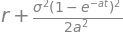

In [5]:
hw1.alpha()

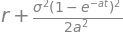

In [6]:
hw1.r_mean()

In [7]:
hw1.r_variance()

In [8]:
hw1.theta()

In [9]:
hw1.B()

In [10]:
hw1.A()

In [11]:
hw1.P()

# Monte Carlo

- define parameters $a$ and $\sigma$
- define $P(0,t)$ function
- compute $\theta(t)$
- define a rate process (Hull-White)
- define a discount process from the rate process
- run the simultion

In [12]:
from init import *
from plot import plot
from plot import plot as sdk_plot
from viz import viz

In [13]:
def create_hw_mc_model (
    a:float,
    sigma:float,
    rfree:float,
    TimeStart    = 0,
    TimeHorizon  = 10,
    TimeSteps    = 100,
    NumPaths     = 100000,
    theta_points = 100
):

    # Create a model, save input parameters

    model = sdk.Model()

    model.TimeStart = TimeStart
    model.TimeSteps = TimeSteps
    model.NumPaths = NumPaths

    model.T = [TimeHorizon/2, TimeHorizon]
    
    model.a_const = a
    model.sigma_const = sigma
    model.rfree_const = rfree
    model.TimeHorizon = TimeHorizon

    # Create the hw-analytical solution
    # to calculate the theta(t) function
    
    model.hw_analytical = HullWhiteAnalytical()
    hwmc = model.hw_analytical
    hwmc.P0_t = exp(-hwmc.r*hwmc.t)
    assert hwmc.r0().subs(hwmc.r,rfree) == rfree

    # Compute theta(t)
    # Create points for linear interpolation of theta(t)
    
    assert theta_points >= 2
    theta = hwmc.theta_lambdify()
    dt = (TimeHorizon-TimeStart) / (theta_points-1)
    model.theta_t = [TimeStart+dt*i for i in range(theta_points)]
    model.theta_y = [theta(a,sigma,rfree,t) for t in model.theta_t]

    # Get the theoretical rate (mean,variance)
    r_mean     = lambdify([hwmc.a,hwmc.sigma,hwmc.r,hwmc.t],hwmc.r_mean())
    r_variance = lambdify([hwmc.a,hwmc.sigma,hwmc.r,hwmc.t],hwmc.r_variance())

    model.rate_gaussian = [
        (r_mean(a,sigma,rfree,t), r_variance(a,sigma,rfree,t))
        for t in model.T
    ]
    
    # Build the model MC engine:
    # - a: mean reversion
    # - sigma
    # - theta
    # - rate
    # - discount factor
        
    print(f'A model with {TimeSteps} time steps and {NumPaths} paths.')

    time_reference = -1
    model.a = model.Add(sdk.Polynom(time_reference,[a],title=f'a={a}'))
    model.sigma = model.Add(sdk.Polynom(time_reference,[sigma],title=f'sigma={sigma}'))
    model.theta = model.Add(sdk.Linear1DInterpolation(
        ref  = time_reference,
        xmin = TimeStart,
        xmax = TimeHorizon,
        y    = model.theta_y,
        title=f'theta(t)'
    ))

    model.rate = model.Add(sdk.Updater(
        'HullWhite1FactorModel',
        refs = [x.GetStateNumber() for x in (model.a,model.theta,model.sigma)],
        start=[rfree],
        title=f'rate'
    ))
    model.df = model.Add(sdk.ZeroCouponBond(underlying=model.rate.GetStateNumber(),start=1,title=f'P({model.TimeStart},T)'))
    model.fdf = model.Add(sdk.Updater('ForwardZeroCouponBond',refs=[model.df.GetStateNumber()],args=[model.T[0],model.T[1]],title=f'P({model.TimeStart},{model.T[0]},{model.T[1]})'))

    return model

In [14]:
#model = create_hw_mc_model(1e-1,2e-1,rfree,theta_points=100)
model = create_hw_mc_model(
    a=1e-1,
    sigma=5e-2,
    rfree=3e-2,
    NumPaths = 1e5,
    TimeSteps = 1e3
    # NumPaths = 1e6,
    # TimeSteps = 1e4
)

A model with 1000.0 time steps and 100000.0 paths.


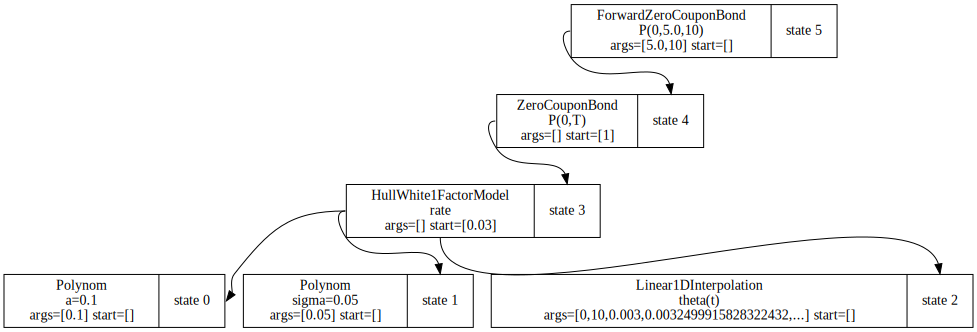

In [15]:
viz(model,graph_attr={'rankdir':'UD'})

### Plot $\theta(t)$ function

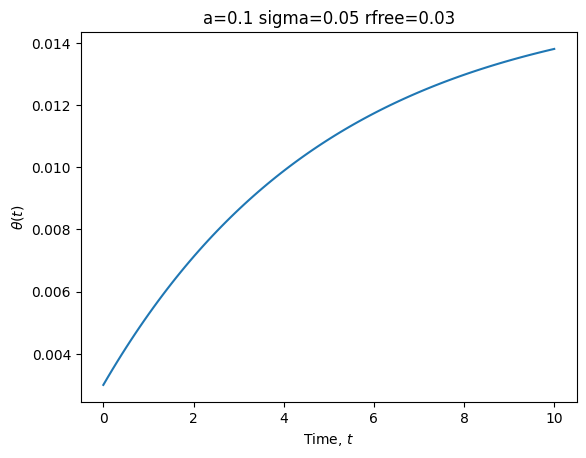

In [16]:
fig, ax = plt.subplots()
ax.plot(model.theta_t, model.theta_y, '-')
ax.set_xlabel('Time, $t$')
ax.set_ylabel('$\\theta(t)$')
ax.set_title(f'a={model.a_const} sigma={model.sigma_const} rfree={model.rfree_const}')
plt.show()

In [17]:
histograms_for_states = [model.rate, model.df, model.fdf]

for t in [model.TimeHorizon/2,model.TimeHorizon]:
    eval_point = sdk.EvaluationPoint(t)
    for h in histograms_for_states:
        eval_point.Add(sdk.Histogram(
            ax = sdk.HistogramAxis(
                h.GetStateNumber(),
                max(int(math.sqrt(model.NumPaths)),10)
            ),
        ))                
    model.evaluations.append(eval_point)

In [18]:
model.RunTimeoutSeconds = 100
results = sdk.run (model, server)
#results.df()
results.df()[['name','title','state','point','time','npaths','mean','stddev']]

,name,title,state,point,time,npaths,mean,stddev
0,Polynom,a=0.1,0,0,5.0,100000,0.100000,0.000000
1,Polynom,sigma=0.05,1,0,5.0,100000,0.050000,0.000000
2,Linear1DInterpolation,theta(t),2,0,5.0,100000,0.010901,0.000000
3,HullWhite1FactorModel,rate,3,0,5.0,100000,0.049405,0.088717
4,ZeroCouponBond,"P(0,T)",4,0,5.0,100000,0.860581,0.236780
5,ForwardZeroCouponBond,"P(0,5.0,10)",5,0,5.0,100000,0.797007,0.369336
6,Polynom,a=0.1,0,1,10.0,100000,0.100000,0.000000
7,Polynom,sigma=0.05,1,1,10.0,100000,0.050000,0.000000
8,Linear1DInterpolation,theta(t),2,1,10.0,100000,0.013808,0.000007
9,HullWhite1FactorModel,rate,3,1,10.0,100000,0.080057,0.103836


### Compare analyticaly and MC computed rate (mean,stddev)

In [19]:
pd.DataFrame([{
    'Method':'Theory',
    f'mean: r(T={model.T[0]})':model.rate_gaussian[0][0],
    f'stddev: r(T={model.T[0]})':math.sqrt(model.rate_gaussian[0][1]),
    f'mean: r(T={model.T[1]})':model.rate_gaussian[1][0],
    f'stddev: r(T={model.T[1]})':math.sqrt(model.rate_gaussian[1][1])
},{
    'Method':'MonteCarlo',
    f'mean: r(T={model.T[0]})':results.GetStateEvaluationResult(model.rate.GetStateNumber(),0).mean,
    f'stddev: r(T={model.T[0]})':results.GetStateEvaluationResult(model.rate.GetStateNumber(),0).stddev,
    f'mean: r(T={model.T[1]})':results.GetStateEvaluationResult(model.rate.GetStateNumber(),1).mean,
    f'stddev: r(T={model.T[1]})':results.GetStateEvaluationResult(model.rate.GetStateNumber(),1).stddev
}])

,Method,mean: r(T=5.0),stddev: r(T=5.0),mean: r(T=10),stddev: r(T=10)
0,Theory,0.049352,0.088890,0.079947,0.103963
1,MonteCarlo,0.049405,0.088717,0.080057,0.103836


#### Conclusion on Rates Comparison
Both _mean_ and _stddev_ values match very well between the theorically prediced rates and the ones obtained from the full MonteCarlo simulation.

### Compare analyticaly and MC computed expected bond value (ok)

In [20]:
hw = model.hw_analytical
#hw.P_lambdify()(hw.a,hw.sigma,hw.r,hw.t)
hw.P().simplify()

In [21]:
Plambda = lambdify([hw.a,hw.sigma,hw.r,hw.t,hw.T],hw.P())
P = lambda t: Plambda (model.a_const,model.sigma_const,model.rfree_const,0,t)

In [22]:
pd.DataFrame([{
    'Method':'Theory',
    f'mean: P(0,T={model.T[0]})':P(model.T[0]),
    f'mean: P(0,T={model.T[1]})':P(model.T[1]),
},{
    'Method':'MonteCarlo',
    f'mean: P(0,T={model.T[0]})':results.GetStateEvaluationResult(model.df.GetStateNumber(),0).mean,
    f'mean: P(0,T={model.T[1]})':results.GetStateEvaluationResult(model.df.GetStateNumber(),1).mean,
}])

,Method,"mean: P(0,T=5.0)","mean: P(0,T=10)"
0,Theory,0.860708,0.740818
1,MonteCarlo,0.860581,0.740244


#### Conclusion on Bond Values Comparison
Expected bond values (_mean_ in the table) match very well between theory and MonteCarlo.

### Rate distribution from the MC

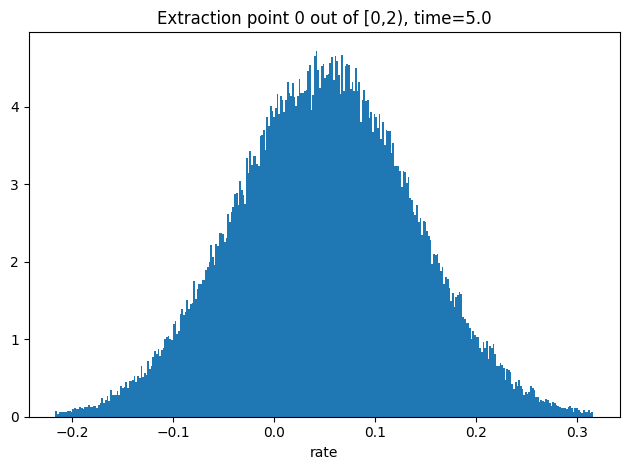

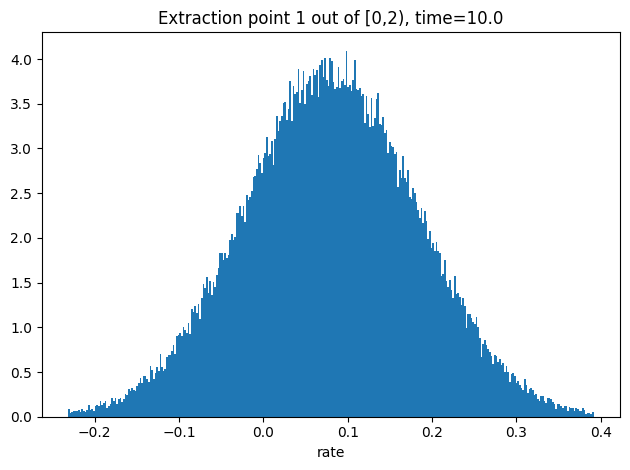

In [23]:
state = model.rate.GetStateNumber()
plot(results=results,point=0,stateX=state)
plot(results=results,point=1,stateX=state)

### Discount factor distribution from the MC

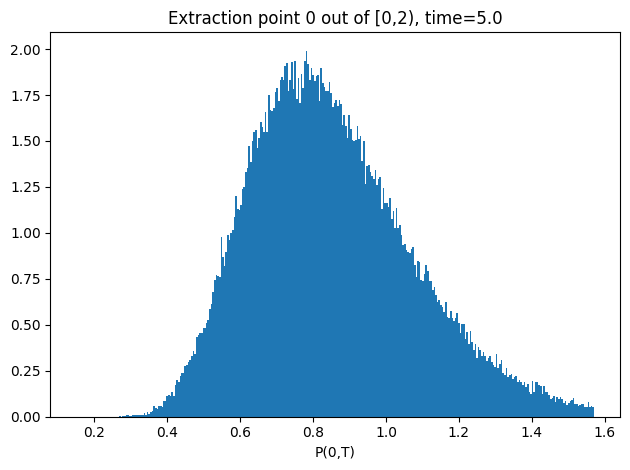

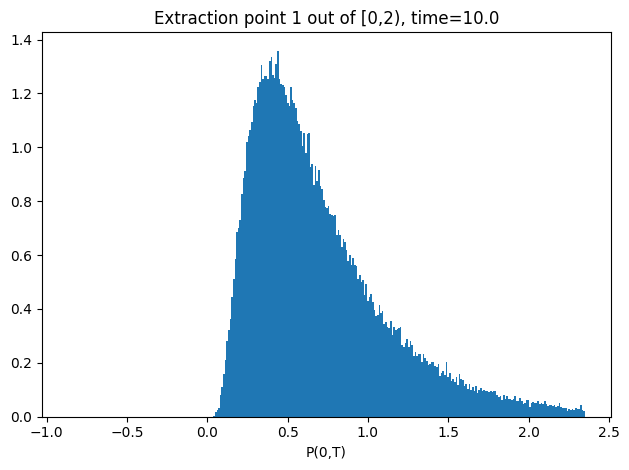

In [24]:
state = model.df.GetStateNumber()
plot(results=results,point=0,stateX=state)
plot(results=results,point=1,stateX=state)

## Stochastic $P(0,t,T)$

In [25]:
random_rate_at_T1 = lambda: random.gauss(model.rate_gaussian[0][0],model.rate_gaussian[0][1])
random_rate_at_T2 = lambda: random.gauss(model.rate_gaussian[1][0],model.rate_gaussian[1][1])

In [26]:
P_0_T1_T2 = lambda: Plambda (model.a_const,model.sigma_const,random_rate_at_T1(),model.T[0],model.T[1])

The random sample: mean=0.736232992767006 stddev=0.02902307121691651


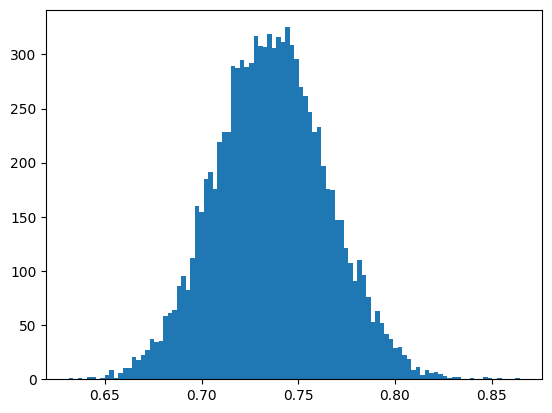

In [27]:
samples = 10000
fig, ax = plt.subplots()
x = [P_0_T1_T2() for i in range(samples)]
x1_sum = sum(x)
x2_sum = sum([v*v for v in x])
x_mean = x1_sum/samples
x_square_mean = x2_sum/samples
x_stddev = math.sqrt(x_square_mean-x_mean**2)
print(f'The random sample: mean={x_mean} stddev={x_stddev}')
ax.hist(np.array(x, dtype=float),bins=100)
plt.show()

## Stochastic $B(0,t,T)$
... From formulas provided by _Emiliano Papa_

In [28]:
class HWEP:
    def __init__ (self):
        self.a, self.t, self.T, self.u, self.s = symbols('a t T u s', real = True, positive = True)
        t = self.t
        T = self.T
        s = self.s
        u = self.u
        k = self.k_t = symbols('k', real = True, positive = True, constant = True)
        sigma = self.sigma_t = symbols('sigma', real = True, positive = True, constant = True)
        self.r1_t_u = integrate(self.k_t,(s,t,u))
        self.G_t_T = integrate(exp(-self.r1_t_u),(u,t,T))
        self.G_u_T = self.G_t_T.subs(t,u)
        self.G_u_t = self.G_u_T.subs(T,t)
        self.sigma_u = self.sigma_t.subs(t,u)
        self.alpha2_t_T = integrate(self.sigma_u**2 * (self.G_u_T-self.G_u_t)**2,(u,0,t))
    
        r = self.r = r = symbols('r', real = True, constant = True)
        self.B_0_t = exp(-r*t)
        self.B_0_T = self.B_0_t.subs(t,T)

        self.X = X = symbols('X', real = True)
        self.B_t_T = self.B_0_T/self.B_0_t * exp(-self.alpha2_t_T/2 - sqrt(self.alpha2_t_T)*X)
        self.B_t_T = self.B_t_T.simplify()
    def B (self):
        return lambdify([self.k_t,self.sigma_t,self.r,self.t,self.T,self.X],self.B_t_T)

In [29]:
hwep = HWEP()

In [30]:
hwep.G_t_T

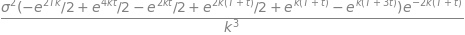

In [31]:
hwep.alpha2_t_T.simplify()

In [32]:
hwep.B_0_t

In [33]:
hwep.B_t_T

In [34]:
B = hwep.B()

### Plot $B(0,5,10)$

The random sample: mean=0.8653895513627229 stddev=0.31012355380758655


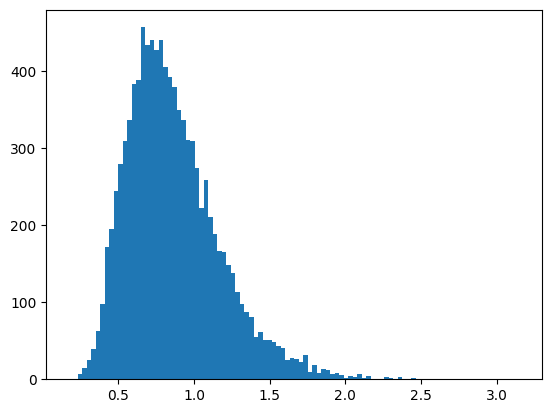

In [35]:
samples = 10000
fig, ax = plt.subplots()
x = [B(model.a_const,model.sigma_const,model.rfree_const,model.T[0],model.T[1],random.gauss(0,1)) for i in range(samples)]
x1_sum = sum(x)
x2_sum = sum([v*v for v in x])
x_mean = x1_sum/samples
x_square_mean = x2_sum/samples
x_stddev = math.sqrt(x_square_mean-x_mean**2)
print(f'The random sample: mean={x_mean} stddev={x_stddev}')
ax.hist(np.array(x, dtype=float),bins=100)
plt.show()

### The full MC generates different $B(0,5,10)$ (comparison failed)

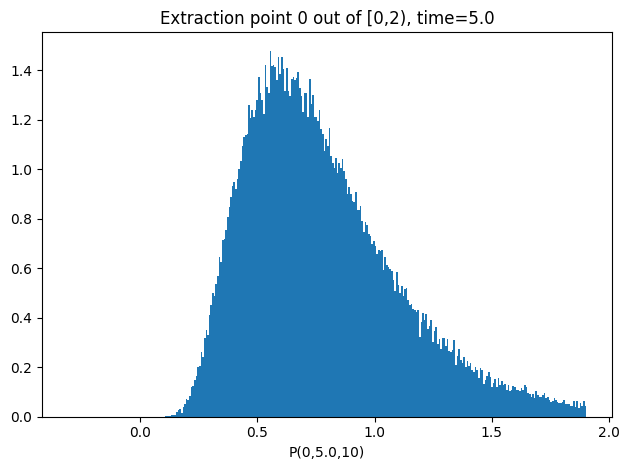

In [36]:
state = model.fdf.GetStateNumber()
sdk_plot(results=results,point=0,stateX=state)

In [37]:
pd.DataFrame([{
    'Method':'Theory',
    f'mean: P(0,t={model.T[0]},T={model.T[1]})':x_mean,
    f'stddev: P(0,t={model.T[0]},T={model.T[1]})':x_stddev,
},{
    'Method':'MonteCarlo',
    f'mean: P(0,t={model.T[0]},T={model.T[1]})':results.GetStateEvaluationResult(model.fdf.GetStateNumber(),0).mean,
    f'stddev: P(0,t={model.T[0]},T={model.T[1]})':results.GetStateEvaluationResult(model.fdf.GetStateNumber(),0).stddev,
}])

,Method,"mean: P(0,t=5.0,T=10)","stddev: P(0,t=5.0,T=10)"
0,Theory,0.865390,0.310124
1,MonteCarlo,0.797007,0.369336


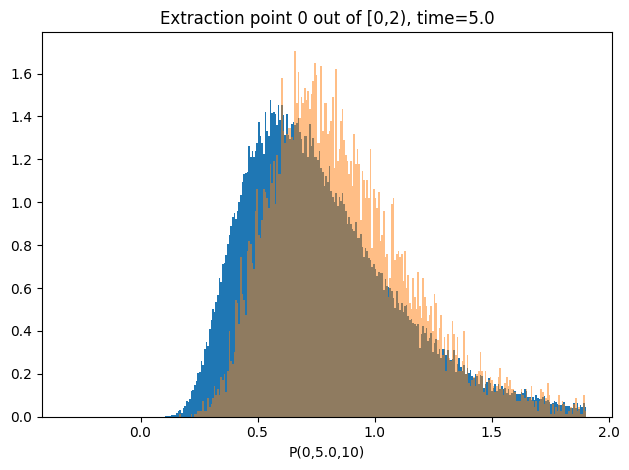

In [38]:
from plot import find as sdk_find

fig,ax,bins = sdk_find(results=results,point=0,stateX=state)
plt.hist(x, bins, alpha=0.5, label='y', density=True)
plt.show()

#### Conclusion on Forward Discount Bond $B(0,t,T)$ Comparison
The values don't match.

# Appendix A: Setting up python environment to run this notebook
Prerequest: please install *python3* and *git* first.

After that, the following set of commands should install all the dependencies and run the notebook.

```bash
pip3 install pandas numpy matplotlib plotly sympy graphviz jupyterlab
git clone https://github.com/AlexanderZvyagin/MonteCarlo-SDK.git
cd MonteCarlo-SDK/python/notebooks
git checkout -b hw origin/hw
jupyter-lab hw_bond.ipynb
```